In [9]:
from math import floor, ceil
import numpy as np
from time import time
from glob import glob
from p_tqdm import p_umap
import pandas as pd
from random import shuffle
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("white")
plt.rcParams['text.usetex'] = True

_precision = 2

def highlight_max(row, props=''):
    return np.where(row.round(_precision) == np.nanmax(row.values).round(_precision), props, '')

def highlight_min(row, props=''):
    return np.where(row.round(_precision) == np.nanmin(row.values).round(_precision), props, '')

def default_style(s):
    s.format(
        precision=_precision,
        na_rep="&mdash;",
        thousands=",",
    )
    s.set_table_styles(
        [
            {
                "selector": "td,th",
                "props": "border: 1px solid black; text-align: center",
            },
            {
                "selector": "td.data",
                "props": "text-align: right; font-family: 'monospace'",
            },            
            {
                "selector": "th",
                "props": "background-color: #D0D0D0 !important; font-weight: normal",
            },
            {
                "selector": "th.row_heading.level1, th.col_heading.level1",
                "props": "background-color: #E0E0E0 !important;",
            },
            {
                "selector": ".index_name,.col_heading.level0",
                "props": "font-weight: bold",
            },
            {
                "selector": ".blank",
                "props": "background-color: white",
            },
        ],
    )
    return s

In [14]:
for metric in ["compress", "time"]:
    data = pd.read_csv("results.csv")
    data["instance"] = data["instance"].str.replace("miplib3/", "")

    summary = (
        data
            .groupby(["instance", "method", "tree"])
            .mean()
            .reset_index()
            .pivot("instance", ("tree", "method"), metric)
            .dropna()
            .T
            .sort_index()
            .T
    )
    
    summary.columns = [
        f"{tree}{method}"
        for tree in ["Fsb", "Rbp"]
        for method in ["Drop", "Heur", "Supp1", "Supp2", "SuppInf"]
    ]

    if metric == "compress":
        for tree in ["Fsb", "Rbp"]:
            summary[f"{tree}Supp2"] = summary[[f"{tree}Supp2", f"{tree}Supp1"]].max(axis=1)
            summary[f"{tree}SuppInf"] = summary[[f"{tree}SuppInf", f"{tree}Supp2"]].max(axis=1)
    
    summary.loc["Mean"] = summary.mean(axis=0)
    summary = summary.round(1)
    summary.to_csv(f"summary_{metric}.csv")
    # summary = data.groupby(["instance", "method", "tree"]).mean()[["time"]]
    # summary.unstack().unstack()

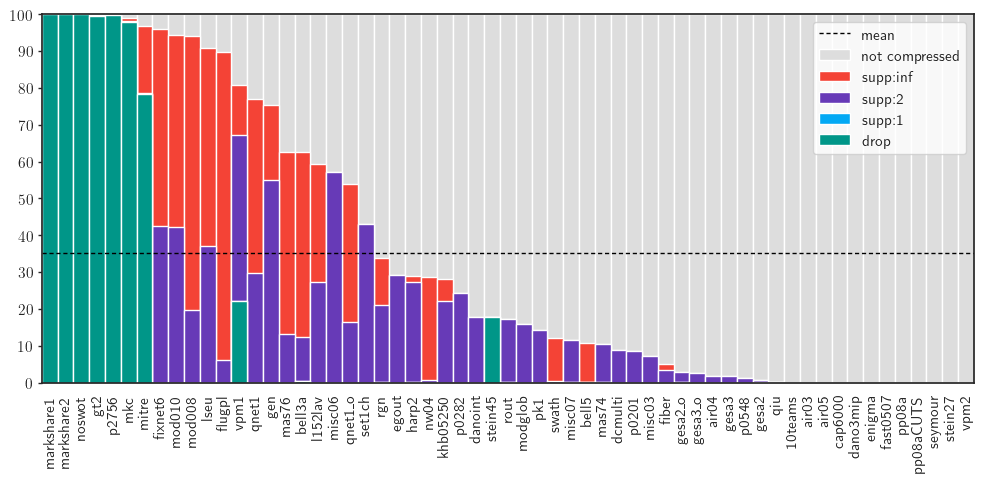

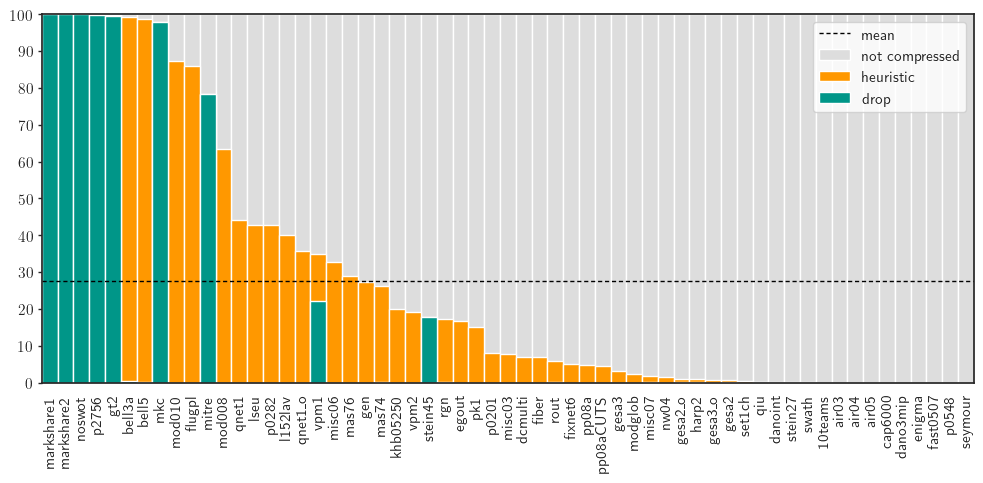

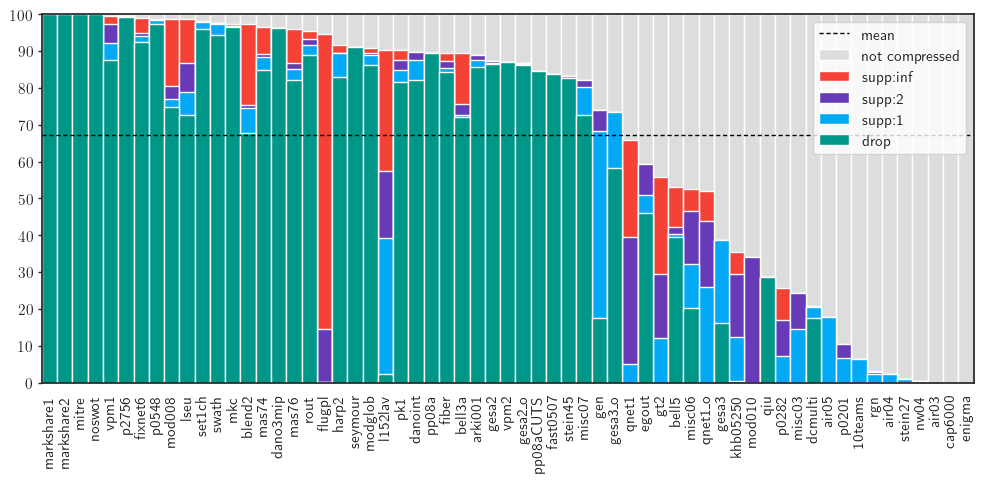

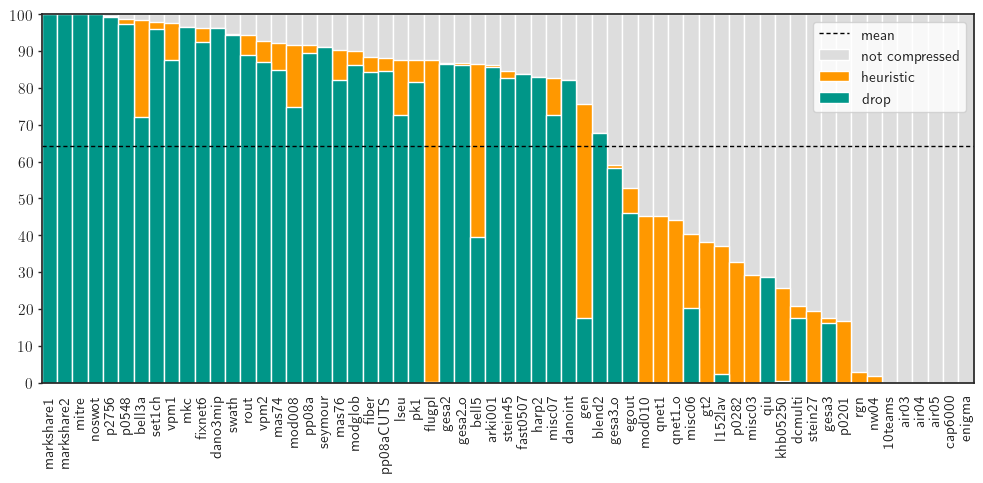

In [18]:
method_groups = {
    "exact": [
        "drop",
        "supp:1",
        "supp:2",
        "supp:inf",
    ],
    "heur": [
        "drop",
        "heuristic",
    ]
}
method_colors = {
    "supp:inf": "#F44336", # red
    "supp:2": "#673AB7", # purple
    "supp:1": "#03A9F4", # blue
    "drop": "#009688", # green
    "heuristic": "#FF9800", # orange
}

for tree in ["FSB", "RBp"]:
    for (methods_name, methods) in method_groups.items():
        filtered = data[data.tree == tree]
        filtered = filtered.groupby(["instance", "method"]).mean().reset_index()
        filtered = filtered.pivot("instance", "method", "compress")[methods]

        for (i, c) in enumerate(filtered.columns):
            if i > 0:
                filtered.iloc[:, i] = filtered.iloc[:, [i-1, i]].max(axis=1)
            filtered = filtered.sort_values(by=c, kind="stable", ascending=False)

        instances = list(filtered.index)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        plt.bar(instances, height=100.0, width=1.0, color="#ddd")
        colors = [method_colors[c] for c in filtered.columns[::-1]]
        mm = filtered[filtered.columns[-1]].mean()
        for (i, c) in enumerate(filtered.columns[::-1]):
            plt.bar(instances, height=filtered[c], width=1.0, color=colors[i])
        plt.axline((0, mm), (1, mm), color="black", dashes=(3,2), linewidth=1)

        plt.legend(
            ["mean", "not compressed"] + list(filtered.columns[::-1]),
            loc="upper right",
        )
        ax.tick_params(
            reset=True,
            axis="y",
            right=False,
            direction='out',
            length=3,
            width=1,
            # colors='r',
            # grid_color='r',
            # grid_alpha=0.5,
        )

        plt.xticks(rotation=90)
        plt.yticks(np.arange(0, 101, step=10))
        plt.margins(y=0, x=0)
        fig.tight_layout()
        plt.savefig(f"{tree}-{methods_name}.pdf")

In [17]:
# titles = [
#     "FSB-exact",
#     "FSB-heur",
#     "RBp-exact",
#     "RBp-heur",
# ]
# for (sheet, title) in zip(["FSB - 5h", "FSB - 15m", "RBp - 5h", "RBp - 15m"], titles):
#     data = pd.read_excel(
#         "summary_miplib3.xlsx",
#         usecols="A,B,F,G,H",
#         skiprows=5,
#         header=None,
#         names=[
#             "instance",
#             "drop",
#             "supp:inf",
#             "supp:2",
#             "supp:1",
#         ],
#         nrows=65,
#         sheet_name=sheet,
#     ).dropna()
#     data = data[[
#         "instance",
#         "drop",
#         "supp:1",
#         "supp:2",
#         "supp:inf",
#     ]]
#     data["instance"] = data.instance.str.replace("miplib3/", "")
#     data = data.set_index("instance")
#     data *= 100
#     for (i, c) in enumerate(data.columns):
#         if i > 0:
#             data.iloc[:, i] = data.iloc[:, [i-1, i]].max(axis=1)
#         data = data.sort_values(by=c, kind="stable", ascending=False)
#     data

#     import matplotlib.pyplot as plt
#     import seaborn as sns

#     sns.set()
#     sns.set_style("white")
#     plt.rcParams['text.usetex'] = True
#     colors = [
#         "#F44336", # red
#         "#673AB7", # purple
#         "#03A9F4", # blue
#         "#009688", # green
#     ]
    
#     mm = data[data.columns[-1]].mean()

#     instance_names = data.index
#     fig = plt.figure(figsize=(10,5))
#     plt.bar(instance_names, height=100.0, width=1.0, color="#ddd")
#     for (i, c) in enumerate(data.columns[::-1]):
#         plt.bar(instance_names, height=data[c], width=1.0, color=colors[i])
#     plt.axline((0, mm), (1, mm), color="black", dashes=(3,2), linewidth=1)

#     plt.xticks(rotation=90)
#     plt.margins(y=0, x=0)
#     fig.tight_layout()

#     # x1 = d["Compression (%)", tree_name, "drop"]
#     # x2 = d["Compression (%)", tree_name, "OweMeh2001"]
#     # plt.bar(instance_names, height=x2, width=1.0, color="#42A5F5")
#     # plt.bar(instance_names, height=x1, width=1.0, color="#0D47A1")

#     # plt.title(title)
#     plt.legend(
#         ["mean", "not compressed"] + list(data.columns[::-1]),
#         loc="upper right",
#     )
#     plt.savefig(f"{title}.png", dpi=150)
#     # plt.savefig(f"{title}.pdf")


In [ ]:
# titles = [
#     f"Compressibility of FSB trees (exact vs heuristic)"
# ]
# for (sheet, title) in zip(["FSB - 5h"], titles):
#     data = pd.read_excel(
#         "summary_miplib3.xlsx",
#         usecols="A,B,F,G,H",
#         skiprows=5,
#         header=None,
#         names=[
#             "instance",
#             "drop",
#             "supp:inf",
#             "supp:2",
#             "supp:1",
#         ],
#         nrows=65,
#         sheet_name=sheet,
#     ).dropna()
#     data["instance"] = data.instance.str.replace("miplib3/", "")
#     data = data[[
#         "instance",
#         "drop",
#         "supp:inf",
#     ]]
#     data = data.set_index("instance")
#     data *= 100
#     data["OweMeh2001"] = owemeh2001
#     data = data[[
#         # "drop",
#         "OweMeh2001",
#         "supp:inf",
#     ]]
#     data.columns = ["heuristic", "exact"]
#     data = data.round()
#     for (i, c) in enumerate(data.columns):
#         if i > 0:
#             data.iloc[:, i] = data.iloc[:, [i-1, i]].max(axis=1)
#         data = data.sort_values(by=c, kind="stable", ascending=False)
#     display(data)
        
#     import matplotlib.pyplot as plt
#     import seaborn as sns

#     sns.set()
#     sns.set_style("white")
#     plt.rcParams['text.usetex'] = True
#     colors = [
#         "#F44336", # red
#         "#03A9F4", # blue
#     ]

#     instance_names = data.index
#     fig = plt.figure(figsize=(10,5))
#     plt.bar(instance_names, height=100.0, width=1.0, color="#ddd")
#     for (i, c) in enumerate(data.columns[::-1]):
#         plt.bar(instance_names, height=data[c], width=1.0, alpha=1, color=colors[i])

#     plt.xticks(rotation=90)
#     plt.margins(y=0, x=0)
#     fig.tight_layout()

#     # x1 = d["Compression (%)", tree_name, "drop"]
#     # x2 = d["Compression (%)", tree_name, "OweMeh2001"]
#     # plt.bar(instance_names, height=x2, width=1.0, color="#42A5F5")
#     # plt.bar(instance_names, height=x1, width=1.0, color="#0D47A1")

#     plt.title(title)
#     plt.legend(
#         ["not compressed"] + list(data.columns[::-1]),
#         loc="upper right",
#     )
#     plt.savefig(f"{title}.png", dpi=150)
